In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rcParams["figure.figsize"] = [10,7]

In [2]:
data = pd.read_csv('AirPassengers.csv')

In [3]:
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
Month          144 non-null object
#Passengers    144 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.3+ KB


In [3]:
date_parser = lambda dates: pd.datetime.strptime(dates,'%Y-%m')

In [4]:
data = pd.read_csv('AirPassengers.csv',parse_dates=['Month'],index_col='Month',date_parser=date_parser)

In [10]:
data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [11]:
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
#Passengers    144 non-null int64
dtypes: int64(1)
memory usage: 2.2 KB


In [13]:
type(data)

pandas.core.frame.DataFrame

In [5]:
ts = data['#Passengers']

In [15]:
type(ts)

pandas.core.series.Series

In [16]:
ts.head()

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

## Stationarity

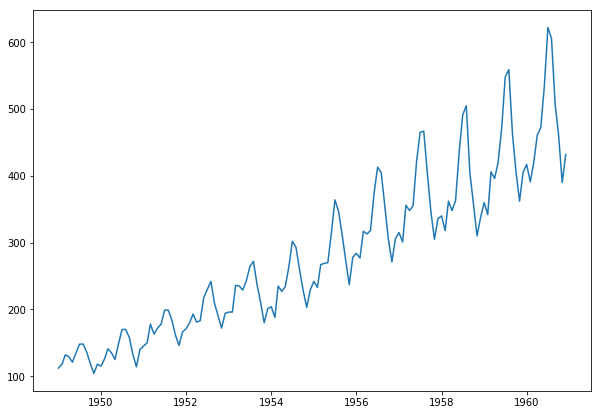

In [6]:
plt.plot(ts)

In [7]:
from statsmodels.tsa.stattools import adfuller

In [28]:
dftest = adfuller(ts, autolag='AIC')

In [31]:
dftest

(0.8153688792060543,
 0.9918802434376411,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

In [8]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = ts.rolling(12).mean()
    rolstd = ts.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

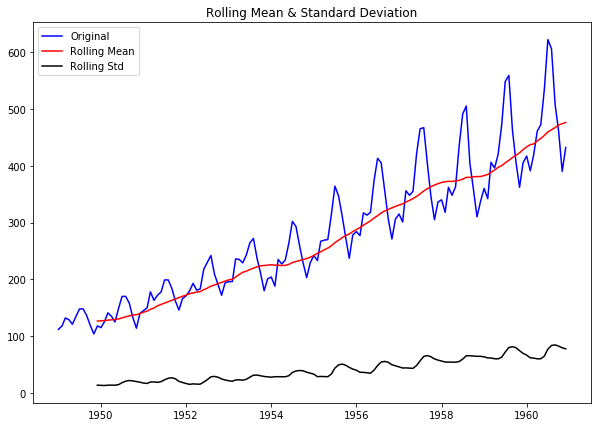

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [9]:
test_stationarity(ts)

##### Test Statistic > Critical ValueS => non stationnary
1. Varying mean over time
2. Seasonality

### Estimating & Eliminating Trend

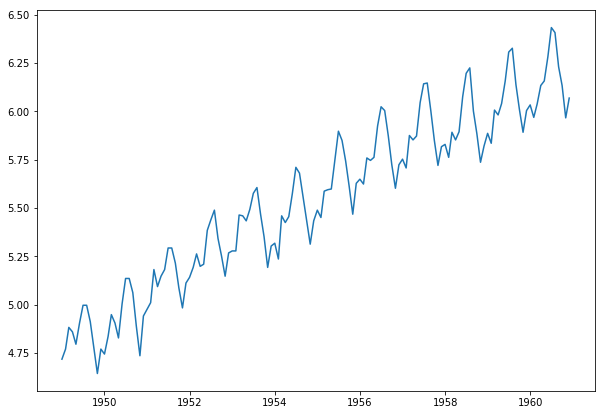

In [20]:
ts_log = np.log(ts)
plt.plot(ts_log)

### Moving Average

In [11]:
moving_avg = ts_log.rolling(12).mean()

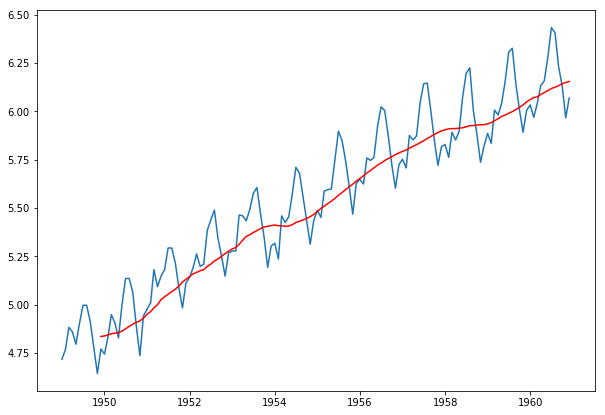

In [12]:
plt.plot(ts_log)
plt.plot(moving_avg,color='red')

In [13]:
ts_log_moving_avg_diff = ts_log - moving_avg

In [14]:
ts_log_moving_avg_diff.head(12)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
Name: #Passengers, dtype: float64

In [17]:
ts_log_moving_avg_diff.dropna(inplace=True)

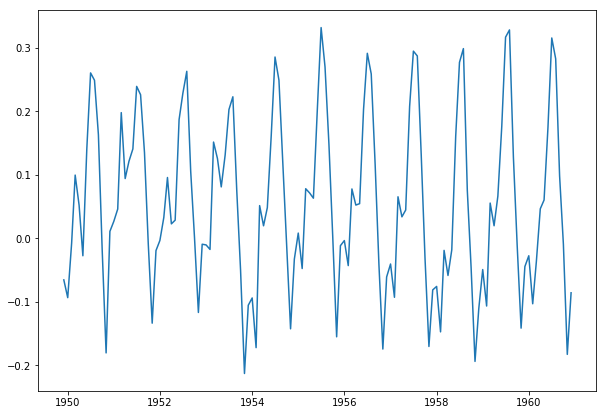

In [18]:
plt.plot(ts_log_moving_avg_diff)

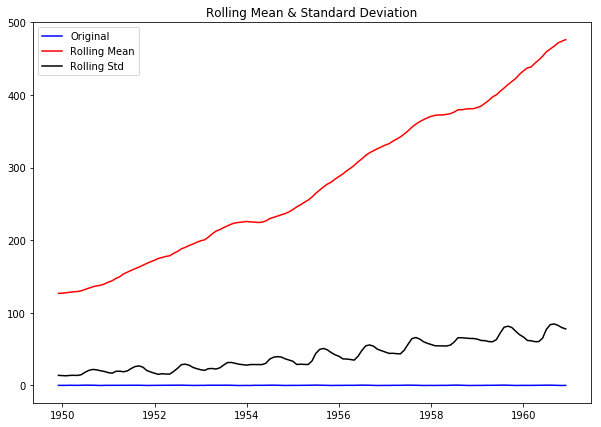

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [19]:
test_stationarity(ts_log_moving_avg_diff)

#### 1% < Test Statistic < 5% < 10% : Test Statistic is smaller than the 5% critical values.
#### We can say with 95% confidence that our series is stationary.

### Exponentially Weighted Moving Average

In [23]:
expwighted_avg = ts_log.ewm(halflife=12).mean()

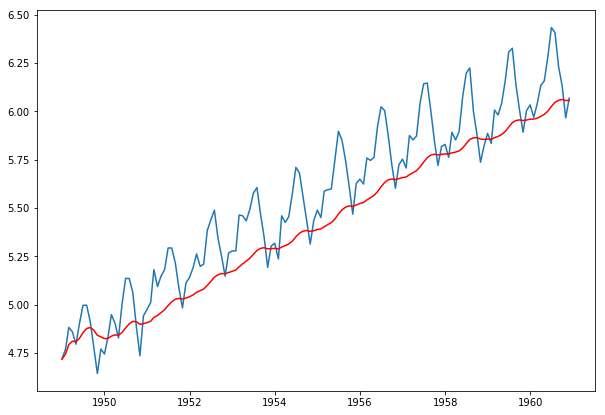

In [24]:
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

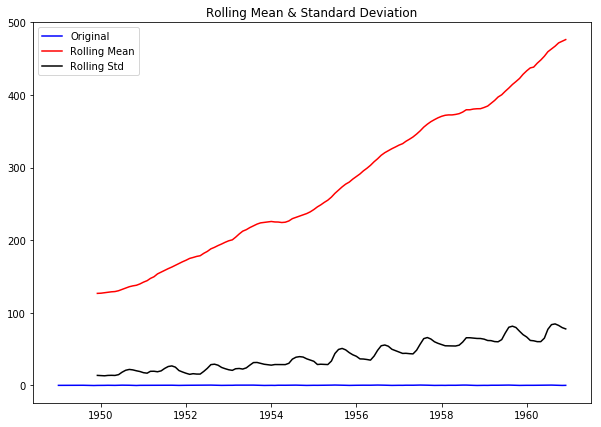

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [26]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

#### Test Statistic < 1% of the critical values => The TS is stationary with 99% confidence.